# Libraries

In [ ]:
import os, re, glob, json, time, random
from pathlib import Path
from copy import deepcopy
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
try:
    from torch.amp import autocast, GradScaler
except Exception:
    from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

# Configuration and Helpers

In [ ]:
try:
    import psutil
except Exception:
    psutil = None

SEED = 2025
import numpy as np, torch, random, time, os
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

EXPORT_ROOT = r"C:\Users\Jerome\Project Design\ModifiedLSTM_Exports"
RUN_STAMP   = time.strftime("%Y%m%d-%H%M%S")
EXPORT_DIR  = os.path.join(EXPORT_ROOT, "HybridLSTMGRU", RUN_STAMP)

CONFIG = { # configuration dictionary
    "DATA_DIRS": [
        r"C:\Users\Jerome\Project Design\KEYPOINTS"
    ],
    # classes auto-detected below
    "SEQUENCE_LENGTH": 48,
    "BATCH_SIZE": 16,
    "EPOCHS": 150,
    "LR": 3e-4,
    "WEIGHT_DECAY": 1e-4,
    "DROPOUT": 0.30,
    "PATIENCE": 10,
    "VAL_SPLIT": 0.15,
    "TEST_SPLIT": 0.15,
    "NORM_MODE": "none",
    "AUG_ON": False, 
    "EXPORT_DIR": EXPORT_DIR,
}

BEST_DIR = r"C:\Users\Jerome\Project Design\ModifiedLSTM_best"
from pathlib import Path
Path(BEST_DIR).mkdir(parents=True, exist_ok=True)
CONFIG["BEST_DIR"] = BEST_DIR

DATASET_DIR = Path(r"C:\Users\Jerome\Project Design\KEYPOINTS")
actions = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
CONFIG["CLASSES"] = actions
print("Discovered classes:", CONFIG["CLASSES"])

# Should be same feature as our extraction
SELECT_JOINTS = [0, 4, 8, 12, 16, 20]
DERIVED_PER_JOINT = 5
DERIVED_DIM = len(SELECT_JOINTS) * 2 * DERIVED_PER_JOINT
BASE_HAND_DIM = 42 * 3
APPEND_FLAGS = True
FEATURE_DIM = BASE_HAND_DIM + DERIVED_DIM + (2 if APPEND_FLAGS else 0)  # 188 total
CONFIG["FEATURE_DIM"] = FEATURE_DIM

# flag indices
FLAG_START = FEATURE_DIM - 2
FLAG_END   = FEATURE_DIM
CONFIG["FLAG_START"] = FLAG_START
CONFIG["FLAG_END"]   = FLAG_END

print(f"Feature dimension set to {FEATURE_DIM} (flags at {FLAG_START}:{FLAG_END})")

Using device: cuda
Discovered classes: ['Color_Black', 'Color_Blue', 'Color_Brown', 'Color_Dark', 'Color_Gray', 'Color_Green', 'Color_Light', 'Color_Orange', 'Color_Pink', 'Color_Red', 'Color_Violet', 'Color_White', 'Color_Yellow', 'Family_Auntie', 'Family_Cousin', 'Family_Daughter', 'Family_Father', 'Family_Grandfather', 'Family_Grandmother', 'Family_Mother', 'Family_Parents', 'Family_Son', 'Family_Uncle', 'Numbers_Eight', 'Numbers_Five', 'Numbers_Four', 'Numbers_Nine', 'Numbers_One', 'Numbers_Seven', 'Numbers_Six', 'Numbers_Ten', 'Numbers_Three', 'Numbers_Two']
Feature dimension set to 188 (flags at 186:188)


In [ ]:
# Helpers
def _next_run_id(dir_path, prefix="run"):
    """
    Scan dir for files or subfolders named like 'run<number>.*' or 'run<number>'.
    Returns the next integer id (starting at 1).
    """
    p = Path(dir_path)
    p.mkdir(parents=True, exist_ok=True)
    pat = re.compile(rf"^{re.escape(prefix)}(\d+)")
    seen = []
    for item in p.iterdir():
        m = pat.match(item.stem)  
        if m:
            try:
                seen.append(int(m.group(1)))
            except ValueError:
                pass
    return (max(seen) + 1) if seen else 1

def _latest_run_id(dir_path, prefix="run"):
    p = Path(dir_path)
    if not p.exists():
        return None
    pat = re.compile(rf"^{re.escape(prefix)}(\d+)")
    seen = []
    for item in p.iterdir():
        m = pat.match(item.stem)
        if m:
            try:
                seen.append(int(m.group(1)))
            except ValueError:
                pass
    return max(seen) if seen else None

# Ensure directory exists
Path(CONFIG["BEST_DIR"]).mkdir(parents=True, exist_ok=True)
RUN_PREFIX = "run"

def _find_latest_run_id(dir_path, prefix=RUN_PREFIX):
    latest = _latest_run_id(dir_path, prefix)
    return latest if latest is not None else 0  # 0 means none yet

CURRENT_RUN_ID = _find_latest_run_id(CONFIG["BEST_DIR"], prefix=RUN_PREFIX)

SKIP_VIDEO_TESTS = False

class Chrono:
    def __enter__(self): 
        self.t0 = time.time(); 
        return self
    def __exit__(self, *exc): 
        self.dt = time.time() - self.t0

def human_time(sec):
    m, s = divmod(int(sec), 60); h, m = divmod(m, 60)
    return f"{h:d}h {m:02d}m {s:02d}s" if h else (f"{m:d}m {s:02d}s" if m else f"{s:d}s")

def report_memory(prefix=""):
    gpu_mem = None
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        gpu_mem = torch.cuda.memory_allocated() / (1024**2)
    ram = psutil.Process().memory_info().rss / (1024**2) if psutil else None
    msg = []
    if ram is not None: msg.append(f"RAM: {ram:.1f} MB")
    if gpu_mem is not None: msg.append(f"GPU: {gpu_mem:.1f} MB")
    print((prefix+" ").strip(), " | ".join(msg))

report_memory("Init mem")
print(f"Exports will be saved to: {CONFIG['EXPORT_DIR']}")

Init mem RAM: 98.2 MB | GPU: 13.8 MB
Exports will be saved to: C:\Users\Jerome\Project Design\ModifiedLSTM_Exports\HybridLSTMGRU\20251018-162711


# Dataset

In [42]:
# Utilities
FLAG_START = CONFIG["FLAG_START"]
FLAG_END   = CONFIG["FLAG_END"]
FEATURE_DIM = CONFIG["FEATURE_DIM"]

def infer_label_from_path(path, classes):
    p = Path(path)
    for c in classes:
        if c in p.parts:
            return classes.index(c)
    stem = p.stem
    for c in classes:
        if stem.startswith(c):
            return classes.index(c)
    raise ValueError(f"Cannot infer label for {path}")

def list_npy_files(data_dirs):
    files = []
    for d in data_dirs:
        if not os.path.isdir(d): continue
        files.extend(glob.glob(str(Path(d) / "**" / "*.npy"), recursive=True))
    return sorted(files)

def effective_length(arr):
    T, D = arr.shape
    if D >= FEATURE_DIM:
        flags = arr[:, FLAG_START:FLAG_END]
        valid = (flags.sum(axis=1) > 0.0)
        if valid.any(): return int(valid.sum())
    coords = arr[:, :min(BASE_HAND_DIM, D)].reshape(T, -1)
    if T <= 1:
        return 1 if np.abs(coords).sum() > 1e-6 else 0
    diffs = np.abs(np.diff(coords, axis=0)).reshape(T-1, -1)
    mag = diffs.mean(axis=1)
    eps = 1e-6
    active = np.zeros(T, dtype=bool)
    active[0] = (mag[0] > eps) if len(mag) else (np.abs(coords[0]).sum() > eps)
    active[1:] = mag > eps
    if active.any(): return int(active.sum())
    nonzero = (np.abs(coords).sum(axis=1) > 1e-6)
    return int(nonzero.sum()) if nonzero.any() else (T if coords.any() else 0)

def _presence_score(arr):
    T, D = arr.shape
    if D >= FEATURE_DIM:
        flags = arr[:, FLAG_START:FLAG_END]
        return ((flags[:,0] > 0.5) | (flags[:,1] > 0.5)).astype(np.float32)
    coords = arr[:, :min(BASE_HAND_DIM, D)]
    if T < 2:
        return (np.abs(coords).sum(axis=1) > 1e-6).astype(np.float32)
    diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
    diffs = np.concatenate([[0.0], diffs])
    rng = diffs.ptp()
    return (diffs - diffs.min()) / (rng + 1e-6)

def _random_crop_start(arr, L):
    T = len(arr)
    if T <= L: return 0
    score = _presence_score(arr)
    k = T - L + 1
    window_scores = np.zeros(k, dtype=np.float32)
    csum = np.concatenate([[0.0], np.cumsum(score)])
    for s in range(k):
        window_scores[s] = csum[s+L] - csum[s]
    probs = window_scores + 1e-6
    probs /= probs.sum()
    return int(np.random.choice(np.arange(k), p=probs))

In [ ]:
FLAG_START = CONFIG["FLAG_START"]
FLAG_END   = CONFIG["FLAG_END"]
FEATURE_DIM = CONFIG["FEATURE_DIM"]

# Data augmentation
def _resample(coords, flags, L):
    T = coords.shape[0]
    if T == L: return coords, flags
    idx = np.linspace(0, T-1, L)
    lo  = np.floor(idx).astype(int)
    hi  = np.clip(lo+1, 0, T-1)
    w   = (idx - lo)[:,None,None]
    c   = (1-w)*coords[lo] + w*coords[hi]
    f   = flags[np.round(idx).astype(int)]
    return c.astype(np.float32), f.astype(np.float32)

def temporal_shift(x, max_shift=3):
    if max_shift <= 0: return x
    T, D = x.shape
    s = np.random.randint(-max_shift, max_shift+1)
    if s == 0: return x
    pad = np.zeros((abs(s), D), np.float32)
    return (np.concatenate([pad, x], 0)[:T] if s > 0
            else np.concatenate([x[-s:], pad], 0)[:T])

def temporal_stretch(x, rmin=0.90, rmax=1.12):
    T, D = x.shape
    r = np.random.uniform(rmin, rmax)
    Lnew = max(8, int(round(T*r)))
    coords = x[:, :BASE_HAND_DIM].reshape(T, 42, 3)
    flags  = x[:, FLAG_START:FLAG_END] if D >= FEATURE_DIM else np.zeros((T, 2), np.float32)
    c, f = _resample(coords, flags, Lnew)
    y = np.zeros((T, D), np.float32)
    Lc = min(Lnew, T)
    y[:Lc, :BASE_HAND_DIM] = c.reshape(Lnew, BASE_HAND_DIM)[:Lc]
    if D >= FEATURE_DIM: y[:Lc, FLAG_START:FLAG_END] = f[:Lc]
    return y

def temporal_dropout(x, max_runs=1, run_len=(1, 2)):
    T, D = x.shape
    coords = x[:, :BASE_HAND_DIM].reshape(T, 42, 3)
    flags  = x[:, FLAG_START:FLAG_END] if D >= FEATURE_DIM else np.zeros((T, 2), np.float32)
    runs = np.random.randint(0, max_runs+1)
    for _ in range(runs):
        k = np.random.randint(run_len[0], run_len[1]+1)
        s = np.random.randint(0, max(1, T-k))
        coords[s:s+k] = 0.0
        if D >= FEATURE_DIM: flags[s:s+k] = 0.0
    x[:, :BASE_HAND_DIM] = coords.reshape(T, BASE_HAND_DIM)
    if D >= FEATURE_DIM: x[:, FLAG_START:FLAG_END] = flags
    return x

def spatial_jitter(x, rot_deg=7.0, scale_j=0.08, trans_j=0.03, noise_std=0.01):
    T, D = x.shape
    coords = x[:, :BASE_HAND_DIM].reshape(T, 42, 3)
    flags  = x[:, FLAG_START:FLAG_END] if D >= FEATURE_DIM else np.zeros((T, 2), np.float32)

    theta = np.deg2rad(np.random.uniform(-rot_deg, rot_deg))
    c, s = np.cos(theta), np.sin(theta)
    R = np.asarray([[c, -s], [s, c]], np.float32)
    sc = 1.0 + np.random.uniform(-scale_j, scale_j)
    tr = np.random.uniform(-trans_j, trans_j, size=(2,)).astype(np.float32)

    xy = coords[..., :2]
    present = (flags.sum(1) > 0.5)[:, None, None] if D >= FEATURE_DIM else np.ones((T,1,1),bool)
    xy = np.where(present, (xy @ R.T) * sc + tr, xy)
    coords[..., :2] = xy

    noise = np.random.normal(0.0, noise_std, size=coords.shape).astype(np.float32)
    coords = np.where(present, coords + noise, coords)

    x[:, :BASE_HAND_DIM] = coords.reshape(T, BASE_HAND_DIM)
    if D >= FEATURE_DIM: x[:, FLAG_START:FLAG_END] = flags
    return x

def random_augment(x):
    if np.random.rand() < 0.8: x = temporal_shift(x, 3)
    if np.random.rand() < 0.6: x = temporal_stretch(x, 0.90, 1.12)
    if np.random.rand() < 0.4: x = temporal_dropout(x, 1, (1, 2))
    if np.random.rand() < 0.7: x = spatial_jitter(x, 7.0, 0.08, 0.03, 0.01)
    return x

In [44]:
class KeypointSequenceDataset(Dataset):
    def __init__(self, files, classes, seq_len, split="train",
                 mean_vec=None, std_vec=None):
        self.files = files
        self.classes = classes
        self.seq_len = seq_len
        self.split = split
        self.mean_vec = mean_vec
        self.std_vec = std_vec

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        f = self.files[idx]
        arr = np.load(f).astype(np.float32)  # (T, D)
        T, D = arr.shape

        # normalize (optional)
        if CONFIG.get("NORM_MODE") == "zscore" and self.mean_vec is not None:
            arr = (arr - self.mean_vec) / self.std_vec

        # apply augmentation (only train)
        if self.split == "train" and CONFIG.get("AUG_ON", False):
            arr = random_augment(arr)

        # pad or trim
        L = self.seq_len
        if T > L:
            arr = arr[:L]
        elif T < L:
            pad = np.zeros((L - T, D), np.float32)
            arr = np.concatenate([arr, pad], axis=0)

        y = infer_label_from_path(f, self.classes)
        return {
            "x": torch.from_numpy(arr),
            "len": torch.tensor(min(T, L)),
            "y": torch.tensor(y, dtype=torch.long),
            "path": f,
        }


def collate_batch(samples):
    xs = torch.stack([s["x"] for s in samples])
    lens = torch.stack([s["len"] for s in samples])
    ys = torch.stack([s["y"] for s in samples])
    paths = [s["path"] for s in samples]
    return xs, lens, ys, paths

In [ ]:
TEST_KEEP_AUG = False

FLAG_START = CONFIG["FLAG_START"]
FLAG_END   = CONFIG["FLAG_END"]
FEATURE_DIM = CONFIG["FEATURE_DIM"]

def base_group(path: str) -> str:
    p = Path(path)
    label = p.parent.name
    stem  = re.sub(r"_aug\d+$", "", p.stem, flags=re.IGNORECASE)
    return f"{label}::{stem}"

def is_augmented(path: str) -> bool:
    return bool(re.search(r"_aug\d+$", Path(path).stem.lower()))

all_files = list_npy_files(CONFIG["DATA_DIRS"])

usable, labels = [], []
for f in all_files:
    try:
        arr = np.load(f, mmap_mode='r')
        if arr.ndim == 2 and arr.shape[1] == FEATURE_DIM:
            usable.append(f)
            labels.append(infer_label_from_path(f, CONFIG["CLASSES"]))
    except Exception:
        pass

assert len(usable) > 0, f"No usable .npy found — expected feature dim {FEATURE_DIM}."
print(f"Total usable samples (pre-filter): {len(usable)}")

# Drop weak clips before splitting
MIN_ACTIVE = 6
M_THR      = 0.02

def motion_active_len(fp, m_thr=M_THR):
    a = np.load(fp)
    if a.ndim != 2 or a.shape[1] != FEATURE_DIM:
        return 0
    T, D = a.shape
    if T < 2: return 0
    coords = a[:, :BASE_HAND_DIM].reshape(T, 42, 3)
    v = np.diff(coords, axis=0)
    m = np.linalg.norm(v, axis=(1,2))
    m = (m - m.min()) / (m.ptp() + 1e-6)
    return int((m > m_thr).sum())

usable_filtered = []
for f in usable:
    try:
        if motion_active_len(f) >= MIN_ACTIVE:
            usable_filtered.append(f)
    except Exception:
        pass

if len(usable_filtered) != len(usable):
    print(f"Filtered out {len(usable) - len(usable_filtered)} weak/idle clips.")
usable = usable_filtered
labels = [infer_label_from_path(f, CONFIG["CLASSES"]) for f in usable]

# build dataframe & group-aware splits
df = pd.DataFrame({"path": usable, "label": labels})
df["group"]  = df["path"].apply(base_group)
df["is_aug"] = df["path"].apply(is_augmented)

df_base = df[~df["is_aug"]].copy()
assert len(df_base) > 0, "No base files found."

grp_lbl_unique = df_base.groupby("group")["label"].nunique()
if not (grp_lbl_unique == 1).all():
    bad = grp_lbl_unique[grp_lbl_unique != 1]
    raise ValueError(f"Mixed labels within base groups: {bad.index.tolist()[:8]} ...")

group_labels_df = df_base.groupby("group")["label"].first().reset_index()
all_groups = group_labels_df["group"].tolist()
all_group_labels = group_labels_df["label"].tolist()

from sklearn.model_selection import train_test_split
TEST_SPLIT = CONFIG["TEST_SPLIT"]
VAL_SPLIT  = CONFIG["VAL_SPLIT"]

grp_trainval, grp_test = train_test_split(
    all_groups,
    test_size=TEST_SPLIT,
    stratify=all_group_labels,
    random_state=SEED
)

remain_mask   = group_labels_df["group"].isin(grp_trainval)
remain_groups = group_labels_df.loc[remain_mask, "group"].tolist()
remain_labels = group_labels_df.loc[remain_mask, "label"].tolist()

val_ratio_of_trainval = VAL_SPLIT / (1.0 - TEST_SPLIT)
grp_train, grp_val = train_test_split(
    remain_groups,
    test_size=val_ratio_of_trainval,
    stratify=remain_labels,
    random_state=SEED
)

grp_train, grp_val, grp_test = set(grp_train), set(grp_val), set(grp_test)

train_files = df[df["group"].isin(grp_train) & (~df["is_aug"])]["path"].tolist()
val_files   = df[df["group"].isin(grp_val)   & (~df["is_aug"])]["path"].tolist()
test_files  = df[df["group"].isin(grp_test)  & (~df["is_aug"])]["path"].tolist()
print("Split sizes (no group overlap):")
print("  Train:", len(train_files))
print("  Val:  ", len(val_files))
print("  Test: ", len(test_files))

def files_to_groups(files): return {base_group(p) for p in files}
assert set(train_files).isdisjoint(val_files)
assert set(train_files).isdisjoint(test_files)
assert set(val_files).isdisjoint(test_files)

def compute_feature_stats(paths, max_files=None):
    xs = []
    for i, f in enumerate(paths):
        if (max_files is not None) and (i >= max_files): break
        a = np.load(f).astype(np.float32)
        xs.append(a)
    X = np.concatenate(xs, axis=0) if len(xs) else np.zeros((1, FEATURE_DIM), np.float32)
    mv = X.mean(axis=0, dtype=np.float64).astype(np.float32)
    sv = X.std(axis=0,  dtype=np.float64).astype(np.float32)
    sv[sv < 1e-6] = 1.0
    return mv, sv

train_mean, train_std = compute_feature_stats(train_files)

train_ds = KeypointSequenceDataset(train_files, CONFIG["CLASSES"], CONFIG["SEQUENCE_LENGTH"],
                                   split="train", mean_vec=train_mean, std_vec=train_std)
val_ds   = KeypointSequenceDataset(val_files,   CONFIG["CLASSES"], CONFIG["SEQUENCE_LENGTH"],
                                   split="val",   mean_vec=train_mean, std_vec=train_std)
test_ds  = KeypointSequenceDataset(test_files,  CONFIG["CLASSES"], CONFIG["SEQUENCE_LENGTH"],
                                   split="test",  mean_vec=train_mean, std_vec=train_std)

train_loader = DataLoader(train_ds, batch_size=CONFIG["BATCH_SIZE"], shuffle=True,
                          collate_fn=collate_batch, num_workers=0, pin_memory=False,
                          persistent_workers=False)
val_loader   = DataLoader(val_ds,   batch_size=CONFIG["BATCH_SIZE"], shuffle=False,
                          collate_fn=collate_batch, num_workers=0, pin_memory=False,
                          persistent_workers=False)
test_loader  = DataLoader(test_ds,  batch_size=CONFIG["BATCH_SIZE"], shuffle=False,
                          collate_fn=collate_batch, num_workers=0, pin_memory=False,
                          persistent_workers=False)

cnt = Counter([infer_label_from_path(p, CONFIG["CLASSES"]) for p in train_files])
class_weights = torch.tensor([1.0/max(1, cnt[i]) for i in range(len(CONFIG["CLASSES"]))], dtype=torch.float32)

Total usable samples (pre-filter): 657
Split sizes (no group overlap):
  Train: 459
  Val:   99
  Test:  99


In [46]:
def _to_split_df(files, split_name):
    return pd.DataFrame({"path": files}).assign(
        split=split_name,
        label=lambda df: df["path"].apply(lambda p: infer_label_from_path(p, CONFIG["CLASSES"])),
        class_name=lambda df: df["label"].apply(lambda i: CONFIG["CLASSES"][i]),
        group=lambda df: df["path"].apply(base_group),
        is_aug=lambda df: df["path"].apply(is_augmented),
    )

df_train = _to_split_df(train_files, "train")
df_val   = _to_split_df(val_files,   "val")
df_test  = _to_split_df(test_files,  "test")

splits_df = pd.concat([df_train, df_val, df_test], ignore_index=True)
splits_df = splits_df.sort_values(["split", "class_name", "group", "path"]).reset_index(drop=True)

# Display a quick summary
print("=== Split sizes ===")
print(splits_df["split"].value_counts().to_string(), "\n")

print("=== Per-class counts per split ===")
summary = splits_df.groupby(["split", "class_name"]).size().unstack(fill_value=0)
print(summary, "\n")

# Show the first few rows per split (full table can be large)
def _peek(df, split_name, n=20):
    print(f"\n--- {split_name.upper()} (showing first {n}) ---")
    display(df.loc[df["split"]==split_name, ["path", "class_name", "group", "is_aug"]].head(n))

_peek(splits_df, "train", 58)
_peek(splits_df, "val",   20)
_peek(splits_df, "test",  20)

# Save full manifest to your export folder
Path(CONFIG["EXPORT_DIR"]).mkdir(parents=True, exist_ok=True)
manifest_path = os.path.join(CONFIG["EXPORT_DIR"], f"splits_manifest_{RUN_STAMP}.csv")
splits_df.to_csv(manifest_path, index=False)
print(f"\nSaved full manifest to:\n  {manifest_path}")

=== Split sizes ===
split
train    459
test      99
val       99 

=== Per-class counts per split ===
class_name  Color_Black  Color_Blue  Color_Brown  Color_Dark  Color_Gray  \
split                                                                      
test                  3           3            3           3           3   
train                14          14           14          14          14   
val                   3           3            3           3           3   

class_name  Color_Green  Color_Light  Color_Orange  Color_Pink  Color_Red  \
split                                                                       
test                  3            3             3           3          3   
train                15           14            14          14         14   
val                   3            3             3           3          3   

class_name  ...  Numbers_Eight  Numbers_Five  Numbers_Four  Numbers_Nine  \
split       ...                                        

,path,class_name,group,is_aug
99,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::0,False
100,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::1,False
101,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::10,False
102,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::11,False
103,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::12,False
104,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::13,False
105,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::14,False
106,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::15,False
107,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::16,False
108,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::19,False



--- VAL (showing first 20) ---


,path,class_name,group,is_aug
558,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::18,False
559,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::2,False
560,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::5,False
561,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Blue,Color_Blue::12,False
562,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Blue,Color_Blue::13,False
563,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Blue,Color_Blue::7,False
564,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Brown,Color_Brown::0,False
565,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Brown,Color_Brown::13,False
566,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Brown,Color_Brown::2,False
567,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Dark,Color_Dark::0,False



--- TEST (showing first 20) ---


,path,class_name,group,is_aug
0,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::17,False
1,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::3,False
2,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Black,Color_Black::9,False
3,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Blue,Color_Blue::14,False
4,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Blue,Color_Blue::15,False
5,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Blue,Color_Blue::16,False
6,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Brown,Color_Brown::12,False
7,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Brown,Color_Brown::5,False
8,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Brown,Color_Brown::7,False
9,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,Color_Dark,Color_Dark::15,False



Saved full manifest to:
  C:\Users\Jerome\Project Design\ModifiedLSTM_Exports\HybridLSTMGRU\20251018-162711\splits_manifest_20251018-162711.csv


In [47]:
def quick_shape_check(paths, max_files=50):
    rows = []
    for i, f in enumerate(paths[:max_files]):
        try:
            a = np.load(f, mmap_mode="r")
            rows.append({
                "path": f,
                "shape": tuple(a.shape),
                "T": a.shape[0] if a.ndim==2 else None,
                "D": a.shape[1] if a.ndim==2 else None,
                "has_flags": (a.ndim==2 and a.shape[1] >= 128),
            })
        except Exception as e:
            rows.append({"path": f, "shape": None, "T": None, "D": None, "has_flags": None, "error": str(e)})
    return pd.DataFrame(rows)

for split_name, files in [("train", train_files), ("val", val_files), ("test", test_files)]:
    print(f"\n=== {split_name.upper()} quick shape check (up to 50 files) ===")
    df_shapes = quick_shape_check(files, max_files=50)
    display(df_shapes.head(30))
    print("Counts by (T,D):")
    print(df_shapes.groupby(["T","D"]).size().to_string())
    if "error" in df_shapes.columns and df_shapes["error"].notna().any():
        print("\nFiles with load errors:")
        display(df_shapes[df_shapes["error"].notna()][["path","error"]])



=== TRAIN quick shape check (up to 50 files) ===


,path,shape,T,D,has_flags
0,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
1,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
2,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
3,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
4,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
5,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
6,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
7,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
8,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
9,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True


Counts by (T,D):
T   D  
48  188    50

=== VAL quick shape check (up to 50 files) ===


,path,shape,T,D,has_flags
0,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
1,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
2,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
3,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
4,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
5,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
6,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
7,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
8,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
9,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True


Counts by (T,D):
T   D  
48  188    50

=== TEST quick shape check (up to 50 files) ===


,path,shape,T,D,has_flags
0,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
1,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
2,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
3,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
4,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
5,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
6,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
7,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
8,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True
9,C:\Users\Jerome\Project Design\KEYPOINTS\Color...,"(48, 188)",48,188,True


Counts by (T,D):
T   D  
48  188    50


# Modified LSTM

In [48]:
class ModifiedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,
                 dropout=0.30, use_layernorm=True):
        super().__init__()
        self.num_layers  = num_layers
        self.hidden_size = hidden_size
        self.use_layernorm = use_layernorm

        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_size if i == 0 else hidden_size,
                hidden_size, batch_first=True,
                dropout=0.0)                     # internal LSTM dropout off
            for i in range(num_layers)
        ])
        if use_layernorm:
            self.layernorms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(num_layers)])

        self.act   = nn.ReLU(inplace=True)
        self.drop  = nn.Dropout(dropout)
        self.fc    = nn.Linear(hidden_size, num_classes)

    def forward(self, x, reset_mask=None):           # x: (B,T,D)
        out = x
        for i, lstm in enumerate(self.lstm_layers):
            out, _ = lstm(out)                        # (B,T,H)
            if self.use_layernorm:
                out = self.layernorms[i](out)         # LN on (B,T,H)
            out = self.act(out)
            out = self.drop(out)

            # Optional gating during idle frames (any-hand present = 1 else 0)
            if reset_mask is not None:
                # reset_mask: (B,T) in {0,1}; when 0, damp contributions
                out = out * reset_mask.unsqueeze(-1)

        # Temporal mean pooling (more stable than last-step)
        out = out.mean(dim=1)                         # (B,H)
        return self.fc(out)                           # (B,C)

def build_modified_lstm(num_classes,
                        input_size=128,
                        hidden_size=256,
                        num_layers=2,
                        dropout=0.35,
                        use_layernorm=True):
    model = ModifiedLSTM(input_size, hidden_size, num_layers, num_classes,
                         dropout=dropout, use_layernorm=use_layernorm)
    return model.to(device)

INPUT_SIZE  = CONFIG["FEATURE_DIM"]
NUM_CLASSES = len(CONFIG["CLASSES"])

model = build_modified_lstm(NUM_CLASSES, input_size=INPUT_SIZE,
                            hidden_size=256, num_layers=2,
                            dropout=CONFIG["DROPOUT"], use_layernorm=True)

total_params = sum(p.numel() for p in model.parameters())
print(f"ModifiedLSTM params: {total_params/1e3:.1f}K  |  Input dim = {INPUT_SIZE}")

ModifiedLSTM params: 992.5K  |  Input dim = 188


In [49]:
FLAG_START = CONFIG["FLAG_START"]
FLAG_END   = CONFIG["FLAG_END"]

# === Training + Inference Time + Last-5 Avg + Model Size (MB) ===
def train_run(TRAIN_FROM_SCRATCH=True, prefix="run"):
    CONFIG["BEST_DIR"] = r"C:\Users\Jerome\Project Design\ModifiedLSTM_best"
    best_dir = Path(CONFIG["BEST_DIR"]); best_dir.mkdir(parents=True, exist_ok=True)

    run_id = _next_run_id(best_dir, prefix=prefix) if TRAIN_FROM_SCRATCH else _latest_run_id(best_dir, prefix=prefix) or 1
    ckpt_name, weights_name = f"{prefix}{run_id}.pt", f"{prefix}{run_id}.pth"
    ckpt_path, weights_path = best_dir / ckpt_name, best_dir / weights_name
    export_dir = Path(CONFIG["EXPORT_DIR"]) / f"{prefix}{run_id}"; export_dir.mkdir(parents=True, exist_ok=True)

    print(f"Training for {CONFIG['EPOCHS']} epochs… ({prefix}{run_id})")

    criterion  = nn.CrossEntropyLoss(weight=class_weights.to(device), label_smoothing=0.05)
    optimizer  = torch.optim.Adam(model.parameters(), lr=CONFIG["LR"], weight_decay=CONFIG["WEIGHT_DECAY"])
    scheduler  = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5, min_lr=1e-5)
    use_cuda   = torch.cuda.is_available()
    scaler     = GradScaler(enabled=use_cuda)
    history = defaultdict(list)
    best_val_loss, best_epoch, no_improve = float("inf"), -1, 0

    def run_one_epoch(loader, train=True):
        model.train(train)
        total_loss = 0; total = 0; correct = 0; inf_times = []
        for x, lens, y, _paths in loader:
            x, y = x.to(device).float(), y.to(device).long()
            reset_mask = (x[..., FLAG_START:FLAG_END].sum(dim=-1) > 0).float()
            if train: optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=use_cuda):
                t0 = time.time()
                logits = model(x, reset_mask=reset_mask)
                t1 = time.time()
                loss = criterion(logits, y)
            if not train: inf_times.append(t1 - t0)
            if train:
                if use_cuda:
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(optimizer); scaler.update()
                else:
                    loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0); optimizer.step()
            with torch.no_grad():
                pred = logits.argmax(1)
                correct += (pred == y).sum().item(); total += y.size(0)
                total_loss += loss.item() * y.size(0)
        inf_ms = (np.mean(inf_times)*1000) if inf_times else 0
        return total_loss/max(1,total), correct/max(1,total), inf_ms

    print("\n=== Training started ===")
    t0 = time.time()
    for epoch in range(CONFIG["EPOCHS"]):
        tr_loss, tr_acc, _ = run_one_epoch(train_loader, True)
        with torch.no_grad():
            va_loss, va_acc, va_inf = run_one_epoch(val_loader, False)
        scheduler.step(va_loss)
        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
        history.setdefault("val_inf_time", []).append(va_inf)
        tag = ""
        if va_loss < best_val_loss - 1e-4:
            best_val_loss, best_epoch, no_improve = va_loss, epoch, 0
            torch.save(model.state_dict(), weights_path)
            torch.save({
                "epoch": epoch, "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "config": CONFIG, "best_val_loss": float(best_val_loss),
                "history": {k:[float(v) for v in vals] for k,vals in history.items()},
            }, ckpt_path)
            tag = f"  <-- BEST (saved {ckpt_name})"
        else:
            no_improve += 1
            if no_improve >= CONFIG["PATIENCE"]:
                print(f"Early stopping (no improve {CONFIG['PATIENCE']} epochs, best@{best_epoch})")
                break
        print(f"Epoch {epoch+1:03d} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f} | inf {va_inf:.2f}ms{tag}")

    print("\n=== [SUMMARY] ===")
    print(f"Best epoch: {best_epoch}, best val loss: {best_val_loss:.4f}")
    print("========================")
    with open(export_dir / "train_history.json", "w") as f:
        json.dump({k:[float(v) for v in vls] for k,vls in history.items()}, f)

train_run(TRAIN_FROM_SCRATCH=True)

Training for 150 epochs… (run23)

=== Training started ===
Epoch 001 | train 3.1917/0.2157 | val 2.7252/0.4646 | inf 4.03ms  <-- BEST (saved run23.pt)
Epoch 002 | train 2.5359/0.4815 | val 2.2169/0.6566 | inf 3.43ms  <-- BEST (saved run23.pt)
Epoch 003 | train 2.0977/0.6492 | val 1.8556/0.6970 | inf 3.57ms  <-- BEST (saved run23.pt)
Epoch 004 | train 1.7687/0.7734 | val 1.6084/0.7475 | inf 3.28ms  <-- BEST (saved run23.pt)
Epoch 005 | train 1.5032/0.8105 | val 1.3397/0.8384 | inf 3.56ms  <-- BEST (saved run23.pt)
Epoch 006 | train 1.2728/0.8911 | val 1.1864/0.8586 | inf 3.21ms  <-- BEST (saved run23.pt)
Epoch 007 | train 1.1169/0.9172 | val 1.0248/0.8889 | inf 2.57ms  <-- BEST (saved run23.pt)
Epoch 008 | train 0.9733/0.9303 | val 0.9310/0.9192 | inf 2.56ms  <-- BEST (saved run23.pt)
Epoch 009 | train 0.8744/0.9390 | val 0.8419/0.9394 | inf 2.57ms  <-- BEST (saved run23.pt)
Epoch 010 | train 0.7984/0.9368 | val 0.7581/0.9495 | inf 2.57ms  <-- BEST (saved run23.pt)
Epoch 011 | train 0.7

# Training with hyperparameter tuning

In [ ]:
HPO_SPACE = {
    "optimizer": ["adam", "adamw"],
    "lr": [7e-4, 5e-4, 3e-4, 2e-4, 1e-4],
    "dropout": [0.40, 0.30, 0.35],
    "weight_decay": [0.0, 1e-6, 1e-5],
    "hidden_size": [256, 320, 384],
    "num_layers": [2, 3],
    "label_smoothing": [0.0, 0.05],
    "scheduler": ["cosine", "plateau"],
}

def sample_candidates(space, n=20, seed=2025):
    rng = random.Random(seed)
    keys = list(space.keys())
    return [{k: rng.choice(space[k]) for k in keys} for _ in range(n)]

candidates = sample_candidates(HPO_SPACE, n=50)
print(f"Testing {len(candidates)} candidate hyperparameter sets")

def quick_eval(hparams, max_epochs=80):
    local_config = deepcopy(CONFIG)
    local_config.update({
        "LR": hparams["lr"],
        "WEIGHT_DECAY": hparams["weight_decay"],
        "DROPOUT": hparams["dropout"],
    })

    model = build_modified_lstm(
        len(local_config["CLASSES"]),
        input_size=local_config["FEATURE_DIM"],
        hidden_size=hparams["hidden_size"],
        num_layers=hparams["num_layers"],
        dropout=hparams["dropout"],
        use_layernorm=True
    )

    criterion = nn.CrossEntropyLoss(
        weight=class_weights.to(device),
        label_smoothing=hparams["label_smoothing"]
    )

    if hparams["optimizer"] == "adam":
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=hparams["lr"],
            weight_decay=hparams["weight_decay"]
        )
    else:
        optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=hparams["lr"],
            weight_decay=hparams["weight_decay"]
        )

    if hparams["scheduler"] == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=5, T_mult=2, eta_min=hparams["lr"] * 0.1
        )
    else:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", patience=4
        )

    scaler = GradScaler(enabled=torch.cuda.is_available())
    best_val_loss = float("inf")
    patience = 15
    bad_epochs = 0
    start = time.time()

    for epoch in range(max_epochs):
        model.train()
        for x, lens, y, _paths in train_loader:
            x, y = x.to(device).float(), y.to(device).long()
            reset_mask = (x[..., CONFIG["FLAG_START"]:CONFIG["FLAG_END"]].sum(dim=-1) > 0).float()
            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=torch.cuda.is_available()):
                logits = model(x, reset_mask=reset_mask)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()

        model.eval()
        total_loss, total = 0.0, 0
        with torch.no_grad():
            for x, lens, y, _paths in val_loader:
                x, y = x.to(device).float(), y.to(device).long()
                reset_mask = (x[..., CONFIG["FLAG_START"]:CONFIG["FLAG_END"]].sum(dim=-1) > 0).float()
                logits = model(x, reset_mask=reset_mask)
                loss = criterion(logits, y)
                total_loss += loss.item() * y.size(0)
                total += y.size(0)
        val_loss = total_loss / max(1, total)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        else:
            scheduler.step(epoch)

        if val_loss < best_val_loss - 1e-4:
            best_val_loss = val_loss
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"early stop @ epoch {epoch+1}")
                break

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"epoch {epoch+1}/{max_epochs} val_loss={val_loss:.4f}")

    elapsed = time.time() - start
    return best_val_loss, elapsed

Testing 50 candidate hyperparameter sets

Candidate 1/50
{'optimizer': 'adam', 'lr': 0.0002, 'dropout': 0.4, 'weight_decay': 1e-05, 'hidden_size': 256, 'num_layers': 3, 'label_smoothing': 0.05, 'scheduler': 'cosine'}
epoch 1/80 val_loss=2.9864
epoch 10/80 val_loss=1.0530
epoch 20/80 val_loss=0.6305
epoch 30/80 val_loss=0.5105
epoch 40/80 val_loss=0.5149
early stop @ epoch 47
Validation loss: 0.5058 (27.0s)

Candidate 2/50
{'optimizer': 'adam', 'lr': 0.0002, 'dropout': 0.3, 'weight_decay': 0.0, 'hidden_size': 256, 'num_layers': 2, 'label_smoothing': 0.0, 'scheduler': 'plateau'}
epoch 1/80 val_loss=2.8937
epoch 10/80 val_loss=0.7717
epoch 20/80 val_loss=0.2543
epoch 30/80 val_loss=0.1729
epoch 40/80 val_loss=0.1716
early stop @ epoch 46
Validation loss: 0.1688 (20.1s)

Candidate 3/50
{'optimizer': 'adam', 'lr': 0.0002, 'dropout': 0.4, 'weight_decay': 1e-05, 'hidden_size': 256, 'num_layers': 2, 'label_smoothing': 0.0, 'scheduler': 'cosine'}
epoch 1/80 val_loss=2.9312
epoch 10/80 val_loss=

The best hyperparameters found were
Best hyperparameters found:
{
    "optimizer": "adamw",
    "lr": 0.0003,
    "dropout": 0.35,
    "weight_decay": 1e-05,
    "hidden_size": 384,
    "num_layers": 2,
    "label_smoothing": 0.0,
    "scheduler": "plateau"
}
Best validation loss: 0.1485 (trained 18.9s)

In [ ]:
results = []
for i, hparams in enumerate(candidates, 1):
    print(f"\nCandidate {i}/{len(candidates)}")
    print(hparams)
    val_loss, elapsed = quick_eval(hparams, max_epochs=80)
    results.append((val_loss, hparams, elapsed))
    print(f"Validation loss: {val_loss:.4f} ({elapsed:.1f}s)")

results.sort(key=lambda x: x[0])
best_loss, best_hparams, t = results[0]
print("\nBest hyperparameters found:")
print(json.dumps(best_hparams, indent=4))
print(f"Best validation loss: {best_loss:.4f} (trained {t:.1f}s)")

In [ ]:
FLAG_START = CONFIG["FLAG_START"]
FLAG_END   = CONFIG["FLAG_END"]

def train_run(TRAIN_FROM_SCRATCH=True, prefix="run"):
    CONFIG["BEST_DIR"] = r"C:\Users\Jerome\Project Design\ModifiedLSTM_best"
    best_dir = Path(CONFIG["BEST_DIR"]); best_dir.mkdir(parents=True, exist_ok=True)

    run_id = _next_run_id(best_dir, prefix=prefix) if TRAIN_FROM_SCRATCH else _latest_run_id(best_dir, prefix=prefix) or 1
    ckpt_name, weights_name = f"{prefix}{run_id}.pt", f"{prefix}{run_id}.pth"
    ckpt_path, weights_path = best_dir / ckpt_name, best_dir / weights_name
    export_dir = Path(CONFIG["EXPORT_DIR"]) / f"{prefix}{run_id}"; export_dir.mkdir(parents=True, exist_ok=True)

    # Apply the best hyperparameters
    CONFIG.update({
        "LR": 5e-4,
        "DROPOUT": 0.35,
        "WEIGHT_DECAY": 1e-6,
        "EPOCHS": 120,
        "PATIENCE": 20,
        "HIDDEN_SIZE": 256,
        "NUM_LAYERS": 2,
        "LABEL_SMOOTHING": 0.0,
        "SCHEDULER": "cosine",       
        "OPTIMIZER": "adamw",        
    })

    model = build_modified_lstm(
        len(CONFIG["CLASSES"]),
        input_size=CONFIG["FEATURE_DIM"],
        hidden_size=CONFIG["HIDDEN_SIZE"],
        num_layers=CONFIG["NUM_LAYERS"],
        dropout=CONFIG["DROPOUT"],
        use_layernorm=True
    ).to(device)

    print(f"Training for {CONFIG['EPOCHS']} epochs… ({prefix}{run_id})")
    print(f"Optimizer={CONFIG['OPTIMIZER']} | lr={CONFIG['LR']} | wd={CONFIG['WEIGHT_DECAY']} | "
          f"dropout={CONFIG['DROPOUT']} | hidden={CONFIG['HIDDEN_SIZE']} | layers={CONFIG['NUM_LAYERS']} | "
          f"sched={CONFIG['SCHEDULER']} | label_smooth={CONFIG['LABEL_SMOOTHING']}")

    criterion  = nn.CrossEntropyLoss(weight=class_weights.to(device),
                                     label_smoothing=CONFIG["LABEL_SMOOTHING"])

    optimizer  = torch.optim.AdamW(model.parameters(),
                                   lr=CONFIG["LR"],
                                   weight_decay=CONFIG["WEIGHT_DECAY"])

    # CosineAnnealingWarmRestarts per HPO best
    scheduler  = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=5, T_mult=2, eta_min=CONFIG["LR"] * 0.1
    )

    use_cuda   = torch.cuda.is_available()
    scaler     = GradScaler(enabled=use_cuda)

    history = defaultdict(list)
    best_val_loss, best_epoch, no_improve = float("inf"), -1, 0

    def run_one_epoch(loader, train=True):
        model.train(train)
        total_loss = 0; total = 0; correct = 0; inf_times = []
        for x, lens, y, _paths in loader:
            x, y = x.to(device).float(), y.to(device).long()
            reset_mask = (x[..., FLAG_START:FLAG_END].sum(dim=-1) > 0).float()
            if train: optimizer.zero_grad(set_to_none=True)
            with autocast(device_type="cuda", enabled=use_cuda):
                t0 = time.time()
                logits = model(x, reset_mask=reset_mask)
                t1 = time.time()
                loss = criterion(logits, y)
            if not train: inf_times.append(t1 - t0)
            if train:
                if use_cuda:
                    scaler.scale(loss).backward()
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    scaler.step(optimizer); scaler.update()
                else:
                    loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); optimizer.step()
            with torch.no_grad():
                pred = logits.argmax(1)
                correct += (pred == y).sum().item(); total += y.size(0)
                total_loss += loss.item() * y.size(0)
        inf_ms = (np.mean(inf_times)*1000) if inf_times else 0
        return total_loss/max(1,total), correct/max(1,total), inf_ms

    print("\nTraining started")
    t0 = time.time()
    for epoch in range(CONFIG["EPOCHS"]):
        tr_loss, tr_acc, _ = run_one_epoch(train_loader, True)

        with torch.no_grad():
            va_loss, va_acc, va_inf = run_one_epoch(val_loader, False)

        # Cosine scheduler: step by epoch index
        scheduler.step(epoch)

        history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
        history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
        history.setdefault("val_inf_time", []).append(va_inf)

        tag = ""
        if va_loss < best_val_loss - 1e-4:
            best_val_loss, best_epoch, no_improve = va_loss, epoch, 0
            torch.save(model.state_dict(), weights_path)
            torch.save({
                "epoch": epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "config": CONFIG,
                "best_val_loss": float(best_val_loss),
                "history": {k:[float(v) for v in vals] for k,vals in history.items()},
            }, ckpt_path)
            tag = f"  <-- best (saved {ckpt_name})"
        else:
            no_improve += 1
            if no_improve >= CONFIG["PATIENCE"]:
                print(f"Early stopping (no improve {CONFIG['PATIENCE']} epochs, best@{best_epoch})")
                break

        print(f"Epoch {epoch+1:03d} | train {tr_loss:.4f}/{tr_acc:.4f} | "
              f"val {va_loss:.4f}/{va_acc:.4f} | inf {va_inf:.2f}ms{tag}")

    total_time = time.time() - t0
    print("\nSummary")
    print(f"Best epoch: {best_epoch}, best val loss: {best_val_loss:.4f}")
    print(f"Total training time: {total_time/60:.2f} minutes")

    with open(export_dir / "train_history.json", "w") as f:
        json.dump({k:[float(v) for v in vls] for k,vls in history.items()}, f)

    torch.save(model.state_dict(), "temp_model_size.pt")
    model_size_mb = os.path.getsize("temp_model_size.pt") / (1024**2)
    os.remove("temp_model_size.pt")
    print(f"Model size: {model_size_mb:.2f} MB")

train_run(TRAIN_FROM_SCRATCH=True)

Training for 120 epochs… (run24)
Optimizer=adamw | lr=0.0005 | wd=1e-06 | dropout=0.35 | hidden=256 | layers=2 | sched=cosine | label_smooth=0.0

Training started
Epoch 001 | train 3.1232/0.1961 | val 2.5906/0.3838 | inf 4.06ms  <-- best (saved run24.pt)
Epoch 002 | train 2.2938/0.4379 | val 1.8812/0.6061 | inf 3.83ms  <-- best (saved run24.pt)
Epoch 003 | train 1.7391/0.6623 | val 1.4491/0.7273 | inf 4.07ms  <-- best (saved run24.pt)
Epoch 004 | train 1.3460/0.7974 | val 1.1539/0.8485 | inf 4.84ms  <-- best (saved run24.pt)
Epoch 005 | train 1.1097/0.8540 | val 1.0256/0.8586 | inf 4.61ms  <-- best (saved run24.pt)
Epoch 006 | train 0.9743/0.9129 | val 0.9368/0.8788 | inf 4.42ms  <-- best (saved run24.pt)
Epoch 007 | train 0.9042/0.8693 | val 0.8430/0.8889 | inf 3.56ms  <-- best (saved run24.pt)
Epoch 008 | train 0.7222/0.9085 | val 0.6472/0.8990 | inf 3.64ms  <-- best (saved run24.pt)
Epoch 009 | train 0.5955/0.9063 | val 0.5702/0.8889 | inf 4.53ms  <-- best (saved run24.pt)
Epoch 010

# Results

[plot] Using history: C:\Users\Jerome\Project Design\ModifiedLSTM_Exports\HybridLSTMGRU\20251018-162711\run24\train_history.json
[plot] Saved: C:\Users\Jerome\Project Design\ModifiedLSTM_Exports\HybridLSTMGRU\20251018-162711\run24\acc_curve.png


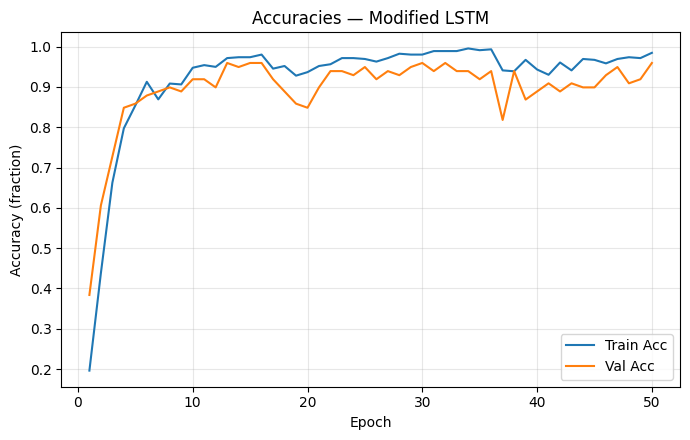

[plot] Saved: C:\Users\Jerome\Project Design\ModifiedLSTM_Exports\HybridLSTMGRU\20251018-162711\run24\loss_curve.png


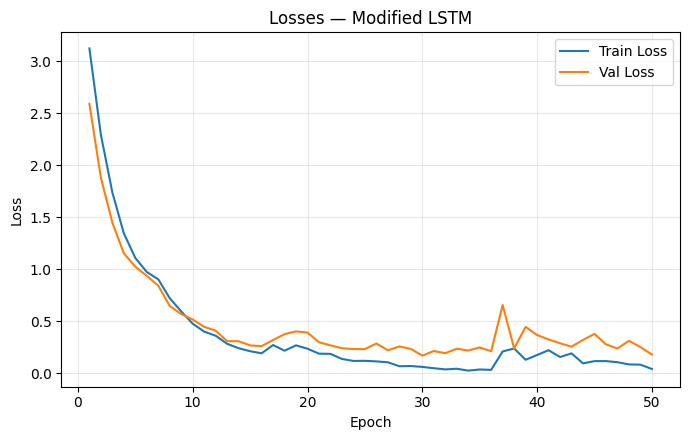

In [52]:
def _coerce_float_list(v):
    try:
        return [float(x) for x in (v if isinstance(v, (list, tuple)) else [])]
    except Exception:
        return []

def load_history_json(json_path):
    """Safe loader for train_history.json when you DO want to load from disk."""
    try:
        with open(json_path, "r") as f:
            hist = json.load(f)
        hist_out = {}
        for k in ("train_acc","val_acc","train_loss","val_loss"):
            hist_out[k] = _coerce_float_list(hist.get(k, []))
        return hist_out
    except Exception as e:
        print(f"[plot] Could not load history from {json_path}: {e}")
        return None

def plot_history(history=None, json_path=None, save_dir=None, title_suffix=""):
    """
    Plot accuracy & loss using decimals (0..1). Prefer `history` (in-memory).
    If `history` is None, tries to load from `json_path`.
    Titles have no run IDs.
    """
    if history is None:
        history = load_history_json(json_path)
    if not history:
        print("[plot] No history found to plot.")
        return

    train_acc = _coerce_float_list(history.get("train_acc"))
    val_acc   = _coerce_float_list(history.get("val_acc"))
    train_ls  = _coerce_float_list(history.get("train_loss"))
    val_ls    = _coerce_float_list(history.get("val_loss"))

    n = max(len(train_acc), len(val_acc), len(train_ls), len(val_ls))
    if n == 0:
        print("[plot] History lists are empty.")
        return
    epochs = list(range(1, n+1))

    def _pad(arr, n):
        arr = list(arr)
        if len(arr) < n:
            arr = arr + [np.nan]*(n-len(arr))
        return arr[:n]

    train_acc = _pad(train_acc, n)
    val_acc   = _pad(val_acc,   n)
    train_ls  = _pad(train_ls,  n)
    val_ls    = _pad(val_ls,    n)

    # --- Accuracy ---
    plt.figure(figsize=(7,4.5))
    plt.plot(epochs, train_acc, label="Train Acc")
    plt.plot(epochs, val_acc,   label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (fraction)")
    plt.title("Accuracies" + (f" — {title_suffix}" if title_suffix else ""))
    plt.grid(True, alpha=0.3); plt.legend(loc="lower right")
    if save_dir:
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        acc_path = str(Path(save_dir) / "acc_curve.png")
        plt.tight_layout(); plt.savefig(acc_path, dpi=150)
        print("[plot] Saved:", acc_path)
    plt.show()

    # --- Loss ---
    plt.figure(figsize=(7,4.5))
    plt.plot(epochs, train_ls, label="Train Loss")
    plt.plot(epochs, val_ls,   label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title("Losses" + (f" — {title_suffix}" if title_suffix else ""))
    plt.grid(True, alpha=0.3); plt.legend(loc="upper right")
    if save_dir:
        loss_path = str(Path(save_dir) / "loss_curve.png")
        plt.tight_layout(); plt.savefig(loss_path, dpi=150)
        print("[plot] Saved:", loss_path)
    plt.show()

cands = glob.glob(os.path.join(CONFIG["EXPORT_DIR"], "run*", "train_history.json"))
if not cands:
    print("[plot] No train_history.json found under", CONFIG["EXPORT_DIR"])
else:
    json_path = max(cands, key=os.path.getmtime)
    save_dir  = os.path.dirname(json_path)
    print("[plot] Using history:", json_path)
    plot_history(history=None, json_path=json_path, save_dir=save_dir, title_suffix="Modified LSTM")

[eval] Loaded checkpoint: run24.pth (run 024)
TTA Test Accuracy: 97.98%


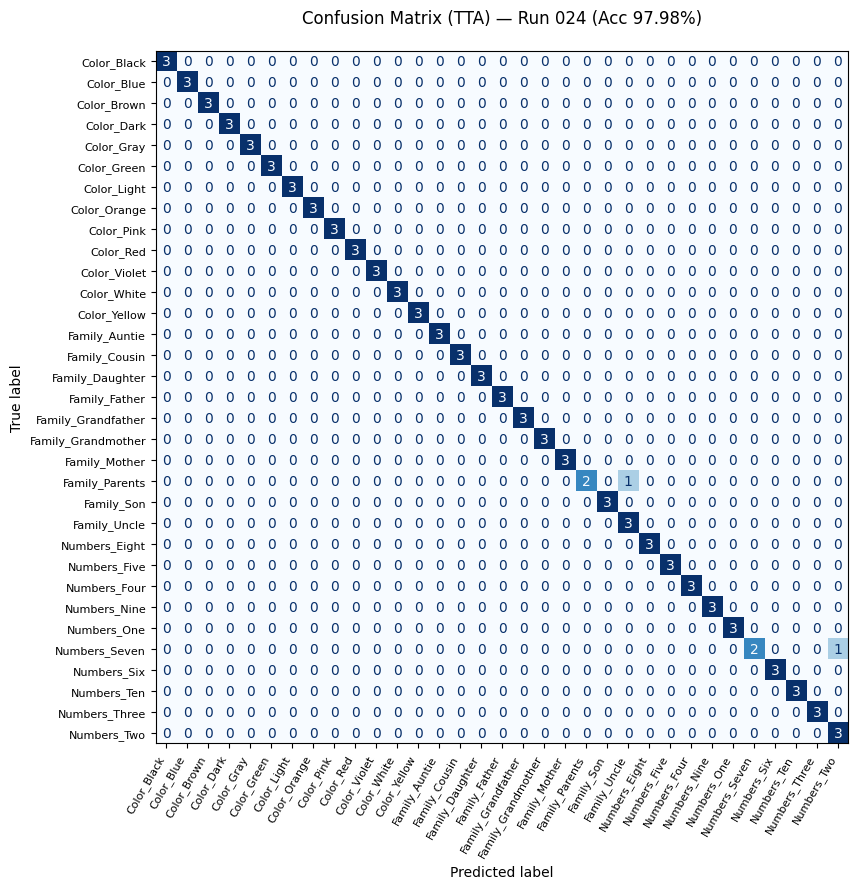

Test Acc 95% CI (Wilson): 92.93% .. 99.44%

Classification Report:

                    precision    recall  f1-score   support

       Color_Black      1.000     1.000     1.000         3
        Color_Blue      1.000     1.000     1.000         3
       Color_Brown      1.000     1.000     1.000         3
        Color_Dark      1.000     1.000     1.000         3
        Color_Gray      1.000     1.000     1.000         3
       Color_Green      1.000     1.000     1.000         3
       Color_Light      1.000     1.000     1.000         3
      Color_Orange      1.000     1.000     1.000         3
        Color_Pink      1.000     1.000     1.000         3
         Color_Red      1.000     1.000     1.000         3
      Color_Violet      1.000     1.000     1.000         3
       Color_White      1.000     1.000     1.000         3
      Color_Yellow      1.000     1.000     1.000         3
     Family_Auntie      1.000     1.000     1.000         3
     Family_Cousin      1.000  

In [ ]:
def latest_ckpt(best_dir, prefix="run"):
    best_dir = Path(best_dir)
    if not best_dir.exists():
        return None, None, None
    cands = []
    for f in best_dir.iterdir():
        m = re.match(rf"^{re.escape(prefix)}(\d+)\.(pt|pth)$", f.name)
        if m:
            cands.append((int(m.group(1)), f, f.suffix))
    if not cands: return None, None, None
    cands.sort(key=lambda x: x[0])
    return cands[-1]

BEST_DIR = r"C:\Users\Jerome\Project Design\ModifiedLSTM_best"
run_id, ckpt_path, ext = latest_ckpt(BEST_DIR)
assert ckpt_path, f"No checkpoint found under {BEST_DIR}"

test_model = build_modified_lstm(
    len(CONFIG["CLASSES"]),
    input_size=CONFIG["FEATURE_DIM"],
    hidden_size=256,          # <- was 320
    num_layers=2,
    dropout=0.35,             # <- was 0.4
    use_layernorm=True
).to(device).eval()

state = torch.load(str(ckpt_path), map_location=device)
test_model.load_state_dict(state if ext == ".pth" else state["model_state_dict"])
print(f"[eval] Loaded checkpoint: {ckpt_path.name} (run {run_id:03d})")

def _tta_variants(x_np, n_nonflip=3):
    T, D = x_np.shape
    FEAT = 126
    coords = x_np[:, :FEAT].reshape(T, 42, 3).copy()
    extra = x_np[:, FEAT:].copy() if D > FEAT else None
    outs = [x_np.astype(np.float32)]
    for _ in range(n_nonflip):
        c = coords.copy()
        ang = np.deg2rad(np.random.uniform(-5, 5))
        R = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]], np.float32)
        xy = c[..., :2].reshape(-1, 2) @ R.T
        c[..., :2] = xy.reshape(T, 42, 2)
        s = np.random.uniform(0.97, 1.05)
        c *= np.array([s, s, 1.0], np.float32)
        flat = np.concatenate([c.reshape(T, FEAT), extra], axis=1) if extra is not None else c.reshape(T, FEAT)
        outs.append(flat.astype(np.float32))
    return outs

FLAG_START, FLAG_END = CONFIG["FLAG_START"], CONFIG["FLAG_END"]
all_preds, all_labels = [], []

with torch.no_grad():
    for x, lens, y, _ in test_loader:
        B, T, D = x.shape
        x_np, y_np = x.cpu().numpy(), y.cpu().numpy()
        logits_sum = torch.zeros((B, len(CONFIG["CLASSES"])), device=device)
        for b in range(B):
            for v in _tta_variants(x_np[b]):
                v_t = torch.from_numpy(v).float().unsqueeze(0).to(device)
                rm = torch.from_numpy((v[:, FLAG_START:FLAG_END].sum(axis=1) > 0).astype(np.float32)).unsqueeze(0).to(device)
                logits_sum[b] += test_model(v_t, reset_mask=rm).squeeze(0)
        all_preds.append(logits_sum.argmax(1).cpu().numpy())
        all_labels.append(y_np)

all_preds, all_labels = np.concatenate(all_preds), np.concatenate(all_labels)
test_acc = (all_preds == all_labels).mean() * 100
print(f"TTA Test Accuracy: {test_acc:.2f}%")

labels_names = CONFIG["CLASSES"]
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(labels_names))))
fig, ax = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay(cm, display_labels=labels_names)
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format="d")
plt.xticks(rotation=60, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.title(f"Confusion Matrix (TTA) — Run {run_id:03d} (Acc {test_acc:.2f}%)", pad=20)
plt.tight_layout()
cm_path = Path(CONFIG["EXPORT_DIR"]) / f"cm_tta_run{run_id:03d}.png"
plt.savefig(cm_path, dpi=200)
plt.show()

# --- 95 % CI and report ---
n = len(all_labels); p = test_acc / 100; z = 1.96
den = 1 + z*z/n
center = (p + z*z/(2*n)) / den
half = z * sqrt((p*(1-p)/n) + (z*z/(4*n*n))) / den
print(f"Test Acc 95% CI (Wilson): {(center-half)*100:.2f}% .. {(center+half)*100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=labels_names, digits=3))
print("Saved confusion matrix to:", cm_path)

[eval] Loaded checkpoint: run24.pth (run 024)

Plain Test Accuracy: 97.98%


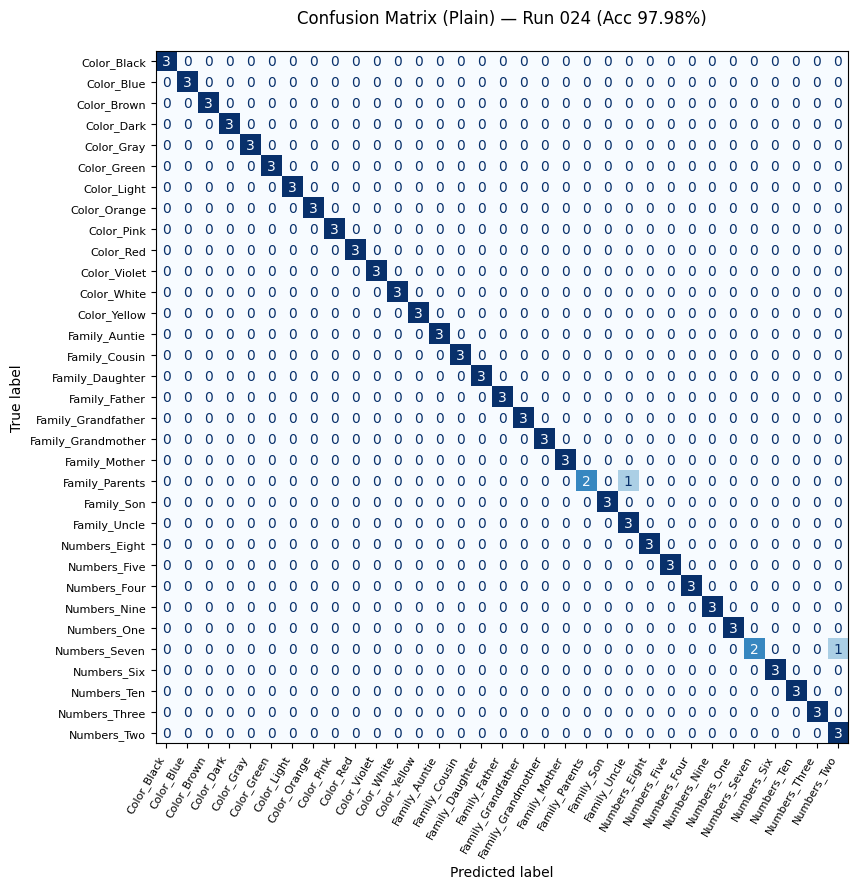


Classification Report:

                    precision    recall  f1-score   support

       Color_Black      1.000     1.000     1.000         3
        Color_Blue      1.000     1.000     1.000         3
       Color_Brown      1.000     1.000     1.000         3
        Color_Dark      1.000     1.000     1.000         3
        Color_Gray      1.000     1.000     1.000         3
       Color_Green      1.000     1.000     1.000         3
       Color_Light      1.000     1.000     1.000         3
      Color_Orange      1.000     1.000     1.000         3
        Color_Pink      1.000     1.000     1.000         3
         Color_Red      1.000     1.000     1.000         3
      Color_Violet      1.000     1.000     1.000         3
       Color_White      1.000     1.000     1.000         3
      Color_Yellow      1.000     1.000     1.000         3
     Family_Auntie      1.000     1.000     1.000         3
     Family_Cousin      1.000     1.000     1.000         3
   Family_Daug

In [54]:
def latest_ckpt(best_dir, prefix="run"):
    best_dir = Path(best_dir)
    if not best_dir.exists():
        return None, None, None
    candidates = []
    for f in best_dir.iterdir():
        m = re.match(rf"^{re.escape(prefix)}(\d+)\.(pt|pth)$", f.name)
        if m:
            run_id = int(m.group(1))
            candidates.append((run_id, f, f.suffix))
    if not candidates:
        return None, None, None
    candidates.sort(key=lambda x: x[0])
    return candidates[-1]

# --- latest checkpoint ---
BEST_DIR = r"C:\Users\Jerome\Project Design\ModifiedLSTM_best"
run_id, ckpt_path, ext = latest_ckpt(BEST_DIR)
assert ckpt_path is not None, f"No checkpoint like 'runN.pth/pt' found under {BEST_DIR}"

# --- rebuild model (Run 22) ---
test_model = build_modified_lstm(
    len(CONFIG["CLASSES"]),
    input_size=CONFIG["FEATURE_DIM"],
    hidden_size=256,          # <- was 320
    num_layers=2,
    dropout=0.35,             # <- was 0.4
    use_layernorm=True
).to(device).eval()

state = torch.load(str(ckpt_path), map_location=device)
test_model.load_state_dict(state if ext == ".pth" else state["model_state_dict"])
print(f"[eval] Loaded checkpoint: {ckpt_path.name} (run {run_id:03d})")

# --- evaluate ---
FLAG_START, FLAG_END = CONFIG["FLAG_START"], CONFIG["FLAG_END"]
all_preds, all_labels = [], []
with torch.no_grad():
    for x, lens, y, _ in test_loader:
        x, y = x.to(device).float(), y.to(device).long()
        reset_mask = (x[..., FLAG_START:FLAG_END].sum(dim=-1) > 0).float()
        logits = test_model(x, reset_mask=reset_mask)
        all_preds.append(logits.argmax(1).cpu().numpy())
        all_labels.append(y.cpu().numpy())

all_preds, all_labels = np.concatenate(all_preds), np.concatenate(all_labels)
acc = (all_preds == all_labels).mean() * 100
print(f"\nPlain Test Accuracy: {acc:.2f}%")

# --- formatted confusion matrix ---
labels_names = CONFIG["CLASSES"]
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(labels_names))))
fig, ax = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay(cm, display_labels=labels_names)
disp.plot(cmap="Blues", ax=ax, colorbar=False, values_format="d")
plt.xticks(rotation=60, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.title(f"Confusion Matrix (Plain) — Run {run_id:03d} (Acc {acc:.2f}%)", pad=20)
plt.tight_layout()
cm_path = Path(CONFIG["EXPORT_DIR"]) / f"cm_plain_run{run_id:03d}.png"
plt.savefig(cm_path, dpi=200)
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=labels_names, digits=3))
print("Saved confusion matrix to:", cm_path)

In [ ]:
HIDDEN_SIZE   = 256    
NUM_LAYERS    = 2
DROPOUT       = 0.35
FEATURE_DIM   = CONFIG["FEATURE_DIM"]          
NUM_CLASSES   = len(CONFIG["CLASSES"])        

class ModifiedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes,
                 dropout=0.30, use_layernorm=True):
        super().__init__()
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.use_layernorm = use_layernorm
        self.lstm_layers = nn.ModuleList([
            nn.LSTM(input_size if i==0 else hidden_size, hidden_size,
                    batch_first=True, dropout=0.0)
            for i in range(num_layers)
        ])
        if use_layernorm:
            self.layernorms = nn.ModuleList([nn.LayerNorm(hidden_size) for _ in range(num_layers)])
        self.act = nn.ReLU(inplace=True)
        self.fc  = nn.Linear(hidden_size, num_classes)

    def forward(self, x, reset_mask=None):
        B, T, _ = x.size()
        h = [torch.zeros(1,B,self.hidden_size,device=x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(1,B,self.hidden_size,device=x.device) for _ in range(self.num_layers)]
        out = x
        for i,lstm in enumerate(self.lstm_layers):
            seq=[]
            for t in range(T):
                _,(h[i],c[i]) = lstm(out[:,t:t+1,:],(h[i],c[i]))
                if reset_mask is not None:
                    mask = reset_mask[:,t].view(1,B,1)
                    h[i]*=mask; c[i]*=mask
                seq.append(h[i].squeeze(0))
            out=torch.stack(seq,1)
            out=self.act(out)
            if self.use_layernorm: out=self.layernorms[i](out)
        return self.fc(out[:,-1,:])

def build_modified_lstm(num_classes, input_size=FEATURE_DIM,
                        hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS,
                        dropout=DROPOUT):
    return ModifiedLSTM(input_size, hidden_size, num_layers,
                        num_classes, dropout=dropout, use_layernorm=True).to(device)

def load_checkpoint(model, ckpt_path: Path):
    state = torch.load(str(ckpt_path), map_location=device)
    if ckpt_path.suffix.lower() == ".pth":
        model.load_state_dict(state)  # raw state_dict
    else:
        # .pt checkpoint dict with "model_state_dict"
        model.load_state_dict(state["model_state_dict"])
    return model

# pick your run
ckpt_path = Path(r"C:\Users\Jerome\Project Design\ModifiedLSTM_best\run24.pt")

model = build_modified_lstm(NUM_CLASSES)
model = load_checkpoint(model, ckpt_path).eval()

print(f"[eval] Loaded checkpoint: {ckpt_path.name}")
print("Params:", sum(p.numel() for p in model.parameters()))

[eval] Loaded checkpoint: run24.pt
Params: 992545


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

print("\nPer-layer parameter count:")
for name, param in model.named_parameters():
    print(f"{name:35s} {param.numel():10,d}")


Total parameters: 992,545
Trainable parameters: 992,545

Per-layer parameter count:
lstm_layers.0.weight_ih_l0             192,512
lstm_layers.0.weight_hh_l0             262,144
lstm_layers.0.bias_ih_l0                 1,024
lstm_layers.0.bias_hh_l0                 1,024
lstm_layers.1.weight_ih_l0             262,144
lstm_layers.1.weight_hh_l0             262,144
lstm_layers.1.bias_ih_l0                 1,024
lstm_layers.1.bias_hh_l0                 1,024
layernorms.0.weight                        256
layernorms.0.bias                          256
layernorms.1.weight                        256
layernorms.1.bias                          256
fc.weight                                8,448
fc.bias                                     33
